In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Imports

In [2]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

In [3]:
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")

In [4]:
train_df[train_df["target"] == 0]["text"].values[10]

"No way...I can't eat that shit"

In [5]:
train_df[train_df["target"] == 1]["text"].values[10]

'Three people died from the heat wave so far'

## 1. Perform proper Text preprocessing steps

* Data cleaning :
   *    Remove special characters and punctuations

In [6]:
def subtext_repeation_in_df(df, col, subtext, num):
    # Calc statistics as table for character repetition (1...num times) from subtext list in the df[col]
    
    text = "".join(df[col])
    result = pd.DataFrame(columns = ['subtext', 'count'])
    i = 0
    if (len(df) > 0) and (len(subtext) > 0):
        for c in subtext:
            for j in range(num):
                cs = c*(j+1)
                result.loc[i,'count'] = text.count(cs)
                if c == ' ':
                    cs = cs.replace(' ','<space>')
                result.loc[i,'subtext'] = cs                
                i += 1
    print('Number of all data is', len(df))
    result = result[result['count'] > 0].reset_index(drop=True)
    display(result.sort_values(by='count',ascending=False))
    
    print('Text examples')
    problem_examples = pd.DataFrame(columns = ['problem_examples'])
    problem_examples['problem_examples'] = ''
    for i in range(len(result)):
        problem_examples.loc[i,'problem_examples'] = df[df[col].str.find(result.loc[i,'subtext'])>-1].reset_index(drop=True).loc[0, col]
    problem_examples = problem_examples.drop_duplicates()
    display(problem_examples)

In [7]:
# Analysis of punctuation marks repetition in training data
print('Statistics for punctuation marks repetition in training data')
subtext_repeation_in_df(train_df, 'text', list(string.punctuation), 10)

Statistics for punctuation marks repetition in training data
Number of all data is 7613


,subtext,count
53,/,14585
43,.,11696
55,:,6910
54,//,4742
10,#,3403
...,...,...
81,]],1
14,$$$,1
79,\\\,1
78,\\,1


Text examples


,problem_examples
0,What a goooooooaaaaaal!!!!!!
6,White family (supposedly representing America'...
10,Our Deeds are the Reason of this #earthquake M...
11,&gt;&gt; $15 Aftershock : Protect Yourself and...
13,Help me win $$$$ by having the most shares on ...
16,#Colorado #Avalanche Men's Official Colorado A...
17,Rene Ablaze &amp; Jacinta - Secret 2k13 (Falle...
18,All residents asked to 'shelter in place' are ...
19,@RedCoatJackpot *As it was typical for them th...
20,@TelegraphWorld lets hope it's a upper class w...


In [8]:
def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [9]:
train_df['text'].iloc[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [10]:
remove_punctuation(train_df['text'].iloc[0])

'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all'

* Case normalization

In [11]:
def to_lowercase(text):
    return text.lower()

In [12]:
to_lowercase(remove_punctuation(train_df['text'].iloc[0]))

'our deeds are the reason of this earthquake may allah forgive us all'

* Replace all Numbers

In [13]:
def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

In [14]:
train_df['text'].iloc[95]

'9 Mile backup on I-77 South...accident blocking the Right 2 Lanes at Exit 31 Langtree Rd...consider NC 115 or NC 150 to NC 16 as alternate'

In [15]:
replace_numbers(to_lowercase(remove_punctuation(train_df['text'].iloc[95])))

' mile backup on i southaccident blocking the right  lanes at exit  langtree rdconsider nc  or nc  to nc  as alternate'

* Words tokenization : create list of words

In [16]:
def text2words(text):
    return word_tokenize(text)

In [17]:
text2words(replace_numbers(to_lowercase(remove_punctuation(train_df['text'].iloc[95]))))

['mile',
 'backup',
 'on',
 'i',
 'southaccident',
 'blocking',
 'the',
 'right',
 'lanes',
 'at',
 'exit',
 'langtree',
 'rdconsider',
 'nc',
 'or',
 'nc',
 'to',
 'nc',
 'as',
 'alternate']

* Remove Stop words like ( 'the', 'to', 'on', 'we',...etc)

In [18]:
def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]

In [19]:
t= text2words(replace_numbers(to_lowercase(remove_punctuation(train_df['text'].iloc[95]))))
remove_stopwords( t, stop_words)

['mile',
 'backup',
 'southaccident',
 'blocking',
 'right',
 'lanes',
 'exit',
 'langtree',
 'rdconsider',
 'nc',
 'nc',
 'nc',
 'alternate']

* Stemming

In [20]:
def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

In [21]:
t= remove_stopwords(text2words(replace_numbers(to_lowercase(remove_punctuation(train_df['text'].iloc[95])))),stop_words)
stem_words(t)

['mile',
 'backup',
 'southaccid',
 'block',
 'right',
 'lane',
 'exit',
 'langtre',
 'rdconsid',
 'nc',
 'nc',
 'nc',
 'altern']

* Another preprocess : Lemmatizing

In [22]:
def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

In [23]:
t= remove_stopwords(text2words(replace_numbers(to_lowercase(remove_punctuation(train_df['text'].iloc[95])))),stop_words)
lemmatize_words(t)

['mile',
 'backup',
 'southaccident',
 'blocking',
 'right',
 'lane',
 'exit',
 'langtree',
 'rdconsider',
 'nc',
 'nc',
 'nc',
 'alternate']

In [24]:
def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])


## Split data 

In [25]:
train_ds_text = train_df.drop(["id","keyword","location"], axis=1)
test_ds_text = test_df.drop(["id","keyword","location"], axis=1)
training_messages = []
test_messages = []
training_labels = []
for index, item in train_ds_text.iterrows():
    message, label = item["text"], item["target"]
    training_messages.append(str(message))
    training_labels.append(label)
    
    
for index, item in test_ds_text.iterrows():
    message = item["text"]
    test_messages.append(str(message))

In [26]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

## 3. Text preparation

In [27]:
def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)
    

    return ''.join(words)

def normalize_corpus(corpus):
    return [normalize_text(t) for t in corpus]

In [28]:
trn_texts = normalize_corpus(training_messages)
tst_texts = normalize_corpus(test_messages)

### * BoW (Binary features)

In [29]:
tok = Tokenizer(num_words=1000, oov_token='UNK')
#tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='binary')
x_test = tok.texts_to_matrix(tst_texts, mode='binary')

In [30]:
y_train = np.asarray(training_labels).astype('float32')

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(7613, 1000)
(7613,)
(3263, 1000)


## 4.Bulid Model

In [32]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

2022-06-28 13:54:57.048557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 13:54:57.169786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 13:54:57.170627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 13:54:57.171917: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20
13/13 [==============================] - 2s 18ms/step - loss: 0.6742 - binary_accuracy: 0.5572 - val_loss: 0.6286 - val_binary_accuracy: 0.6990
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6302 - binary_accuracy: 0.6449 - val_loss: 0.5852 - val_binary_accuracy: 0.7730
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5817 - binary_accuracy: 0.7472 - val_loss: 0.5486 - val_binary_accuracy: 0.8070
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5360 - binary_accuracy: 0.7945 - val_loss: 0.5205 - val_binary_accuracy: 0.8120
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4949 - binary_accuracy: 0.8149 - val_loss: 0.5034 - val_binary_accuracy: 0.8120
Epoch 6/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4585 - binary_accuracy: 0.8216 - val_loss: 0.5051 - val_binary_accuracy: 0.7750
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4

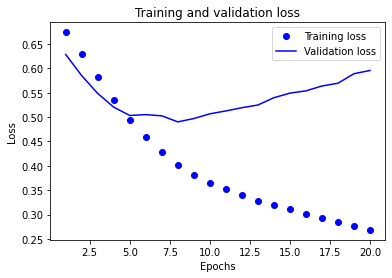

In [33]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

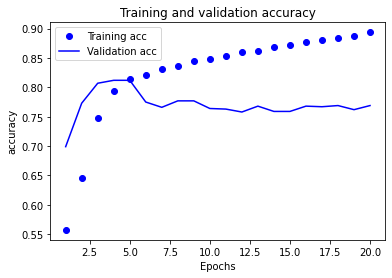

In [34]:


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## Preparing Submission File

In [35]:
# model = models.Sequential()
# model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

# model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=4,
#                     batch_size=512,
#                     validation_data=(x_val, y_val))

In [36]:
# result = model.predict(x_test)

In [37]:
# result

In [38]:
# result[result>=0.5]=1
# result[result<0.5]=0

In [39]:
# result

In [40]:
# sample_submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
# sample_submission['target']=result
# sample_submission['target']=sample_submission['target'].astype(int)

In [41]:
#sample_submission.head()
# sample_submission.to_csv('submission.csv', index=False)

In [42]:
### using count
x_train = tok.texts_to_matrix(trn_texts, mode='count')
x_test = tok.texts_to_matrix(tst_texts, mode='count')

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
13/13 [==============================] - 1s 16ms/step - loss: 0.6802 - binary_accuracy: 0.5622 - val_loss: 0.6385 - val_binary_accuracy: 0.7080
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6501 - binary_accuracy: 0.6262 - val_loss: 0.6104 - val_binary_accuracy: 0.7410
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6122 - binary_accuracy: 0.7157 - val_loss: 0.5786 - val_binary_accuracy: 0.7660
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5696 - binary_accuracy: 0.7688 - val_loss: 0.5489 - val_binary_accuracy: 0.7720
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5272 - binary_accuracy: 0.7983 - val_loss: 0.5291 - val_binary_accuracy: 0.7930
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.4879 - binary_accuracy: 0.8167 - val_loss: 0.5180 - val_binary_accuracy: 0.7930
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.4

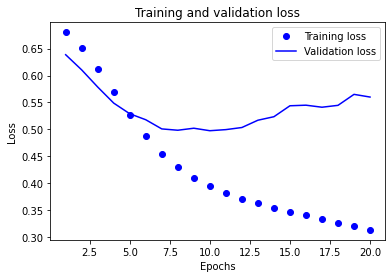

In [43]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

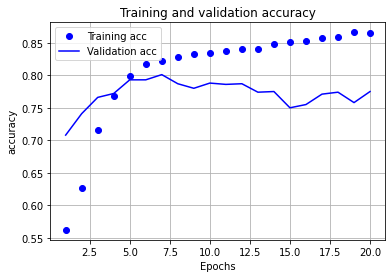

In [44]:


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

## Preparing Submission File

In [45]:
# model = models.Sequential()
# model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

# model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=5,
#                     batch_size=512,
#                     validation_data=(x_val, y_val))

In [46]:
# result = model.predict(x_test)
# result[result>=0.5]=1
# result[result<0.5]=0
# result

In [47]:
# sample_submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
# sample_submission['target']=result
# sample_submission['target']=sample_submission['target'].astype(int)
# #sample_submission.head()
# sample_submission.to_csv('submission.csv', index=False)

In [48]:
### using freq
x_train = tok.texts_to_matrix(trn_texts, mode='freq')
x_test = tok.texts_to_matrix(tst_texts, mode='freq')

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
13/13 [==============================] - 1s 16ms/step - loss: 0.6872 - binary_accuracy: 0.5512 - val_loss: 0.6612 - val_binary_accuracy: 0.6950
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.6721 - binary_accuracy: 0.5894 - val_loss: 0.6387 - val_binary_accuracy: 0.7050
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6525 - binary_accuracy: 0.6321 - val_loss: 0.6277 - val_binary_accuracy: 0.7700
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 0.6313 - binary_accuracy: 0.6862 - val_loss: 0.6115 - val_binary_accuracy: 0.7700
Epoch 5/20
13/13 [==============================] - 0s 5ms/step - loss: 0.6082 - binary_accuracy: 0.7314 - val_loss: 0.5825 - val_binary_accuracy: 0.7800
Epoch 6/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5834 - binary_accuracy: 0.7577 - val_loss: 0.5644 - val_binary_accuracy: 0.7740
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5

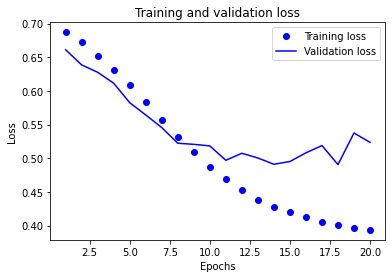

In [49]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

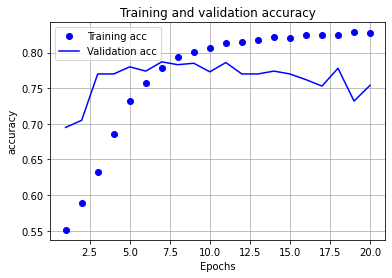

In [50]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

## Preparing Submission File

In [51]:
# model = models.Sequential()
# model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

# model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=10,
#                     batch_size=512,
#                     validation_data=(x_val, y_val))

In [52]:
# result = model.predict(x_test)
# result[result>=0.5]=1
# result[result<0.5]=0
# sample_submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
# sample_submission['target']=result
# sample_submission['target']=sample_submission['target'].astype(int)
# #sample_submission.head()
# sample_submission.to_csv('submission.csv', index=False)

## Use LSTM 

In [53]:
maxlen = max([len(t) for t in trn_texts])

In [54]:
maxlen

137

In [55]:
l=[len(t) for t in trn_texts]

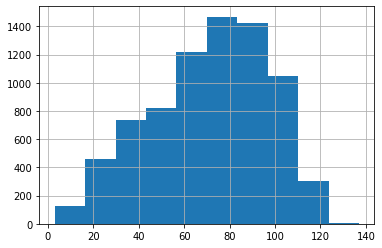

In [56]:
plt.hist(l)
plt.grid()

In [57]:
maxlen=80

In [58]:
training_messages2 = tok.texts_to_sequences(trn_texts)

training_padded = pad_sequences(training_messages2,
                                maxlen=maxlen, 
                                truncating='post', 
                                padding='post'
                               )

In [59]:
# #tst_texts
test_messages = tok.texts_to_sequences(tst_texts)

test_padded = pad_sequences(test_messages,
                                maxlen=maxlen, 
                                truncating='post', 
                                padding='post'
                               )

In [60]:
training_padded = np.array(training_padded)
x_val = training_padded[:1000]
partial_x_train = training_padded[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

model = models.Sequential()
model.add(layers.Embedding(1000, 20, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(50, dropout=0.2)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=[metrics.binary_accuracy]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 20)            20000     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               28400     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=35,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/35


2022-06-28 13:55:18.547741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


52/52 [==============================] - 5s 25ms/step - loss: 0.6864 - binary_accuracy: 0.5439 - val_loss: 0.6451 - val_binary_accuracy: 0.6950
Epoch 2/35
52/52 [==============================] - 1s 12ms/step - loss: 0.6705 - binary_accuracy: 0.5656 - val_loss: 0.6025 - val_binary_accuracy: 0.7070
Epoch 3/35
52/52 [==============================] - 1s 12ms/step - loss: 0.6350 - binary_accuracy: 0.6682 - val_loss: 0.5804 - val_binary_accuracy: 0.7510
Epoch 4/35
52/52 [==============================] - 1s 12ms/step - loss: 0.5829 - binary_accuracy: 0.7106 - val_loss: 0.5292 - val_binary_accuracy: 0.7760
Epoch 5/35
52/52 [==============================] - 1s 15ms/step - loss: 0.5288 - binary_accuracy: 0.7478 - val_loss: 0.4907 - val_binary_accuracy: 0.7860
Epoch 6/35
52/52 [==============================] - 1s 13ms/step - loss: 0.4947 - binary_accuracy: 0.7647 - val_loss: 0.5118 - val_binary_accuracy: 0.7890
Epoch 7/35
52/52 [==============================] - 1s 12ms/step - loss: 0.4710 -

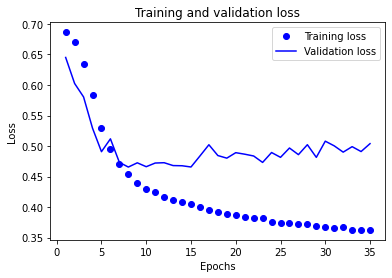

In [62]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

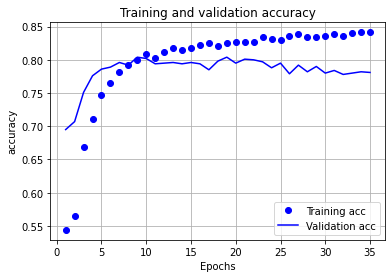

In [63]:


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

## Preparing Submission File


In [64]:
model = models.Sequential()
model.add(layers.Embedding(1000, 20, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(50, dropout=0.2)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=[metrics.binary_accuracy]
)


model.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/15
52/52 [==============================] - 4s 31ms/step - loss: 0.6864 - binary_accuracy: 0.5516 - val_loss: 0.6460 - val_binary_accuracy: 0.6950
Epoch 2/15
52/52 [==============================] - 1s 12ms/step - loss: 0.6738 - binary_accuracy: 0.5689 - val_loss: 0.6271 - val_binary_accuracy: 0.7240
Epoch 3/15
52/52 [==============================] - 1s 12ms/step - loss: 0.6426 - binary_accuracy: 0.6640 - val_loss: 0.5811 - val_binary_accuracy: 0.7490
Epoch 4/15
52/52 [==============================] - 1s 13ms/step - loss: 0.6069 - binary_accuracy: 0.6945 - val_loss: 0.5430 - val_binary_accuracy: 0.7640
Epoch 5/15
52/52 [==============================] - 1s 13ms/step - loss: 0.5586 - binary_accuracy: 0.7293 - val_loss: 0.5137 - val_binary_accuracy: 0.7860
Epoch 6/15
52/52 [==============================] - 1s 14ms/step - loss: 0.5070 - binary_accuracy: 0.7596 - val_loss: 0.5165 - val_binary_accuracy: 0.7850
Epoch 7/15
52/52 [==============================] - 1s 12ms/step - los

In [65]:
result = model.predict(test_padded)
result[result>=0.5]=1
result[result<0.5]=0
sample_submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sample_submission['target']=result
sample_submission['target']=sample_submission['target'].astype(int)
#sample_submission.head()
sample_submission.to_csv('submission.csv', index=False)